# Seasonal and Temporal Analysis

This notebook provides detailed analysis of seasonal patterns, daily cycles, and temporal trends in solar energy production.

**Key Analysis:**
- Monthly and seasonal production patterns
- Daily production curves and peak hours
- Year-over-year trends
- System performance over time

In [1]:
# Import libraries
import sys
sys.path.append('../src')

from core.data_manager import SolarDataManager
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📈 Solar Energy Data Analysis - Seasonal & Temporal Patterns")
print("=" * 65)

📈 Solar Energy Data Analysis - Seasonal & Temporal Patterns


/Users/christopherhaught/projects/power-usage-and-consumption/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Load Data

In [ ]:
# Initialize data manager using smart data source detection
from core.data_source_detector import DataSourceDetector
from core.location_loader import create_notebook_location

# Initialize location from .env (with fallback to Denver)
location = create_notebook_location()
print(f"🌍 Location configured: {location.location_name}")
print(f"📍 Coordinates: {location.latitude:.3f}°N, {location.longitude:.3f}°W")

# Initialize the smart data source detector
detector = DataSourceDetector(location=location)

# Determine the optimal data loading strategy
strategy = detector.determine_data_strategy()

# Initialize data manager with the detected strategy
data_manager = SolarDataManager(
    csv_path=strategy['csv_path'], 
    enphase_client=strategy['client'],
    cache_dir="../data/processed"
)

print("✅ Data manager initialized with location-aware configuration")

# Load and prepare data using smart data source detection
daily_data = data_manager.get_daily_production(source_priority="csv_first")
csv_data = data_manager.load_csv_data()

# Get comprehensive data summary and recency analysis
data_summary = data_manager.get_data_summary()
recency_info = detector.analyze_data_recency(csv_data, data_summary)

# Generate comprehensive data source report
detector.generate_final_report(strategy, data_summary, recency_info)

print(f"\n✅ Loaded {len(daily_data)} days of daily data")
print(f"✅ Loaded {len(csv_data):,} 15-minute intervals")
print(f"📅 Date range: {daily_data.index.min().date()} to {daily_data.index.max().date()}")

# Add location-specific context
print(f"\n🌍 Location-Specific Analysis:")
print(f"  System location: {location.location_name}")
print(f"  Climate type: {location.get_location_summary()['climate_type']}")

# Calculate expected vs actual patterns based on location
import datetime
today = datetime.date.today()
expected_sunrise, expected_sunset = location.get_sunrise_sunset(today)
expected_daylight = expected_sunset - expected_sunrise

print(f"  Expected daylight hours (today): {expected_daylight:.1f} hours")
print(f"  Summer daylight range: {location.get_location_summary()['summer_daylight_hours']:.1f} hours")
print(f"  Winter daylight range: {location.get_location_summary()['winter_daylight_hours']:.1f} hours")

In [3]:
# Monthly analysis
monthly_stats = daily_data.groupby(daily_data.index.month).agg({
    'Production (kWh)': ['mean', 'sum', 'std', 'max', 'min']
}).round(2)

monthly_stats.columns = ['Avg Daily', 'Total', 'Std Dev', 'Peak Day', 'Min Day']

print("=== MONTHLY PRODUCTION STATISTICS ===")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_stats.index = [month_names[i-1] for i in monthly_stats.index]
print(monthly_stats)

# Find best and worst months
best_month = monthly_stats['Avg Daily'].idxmax()
worst_month = monthly_stats['Avg Daily'].idxmin()
print(f"\n🌞 Best production month: {best_month} ({monthly_stats.loc[best_month, 'Avg Daily']:.1f} kWh/day avg)")
print(f"☁️ Lowest production month: {worst_month} ({monthly_stats.loc[worst_month, 'Avg Daily']:.1f} kWh/day avg)")
print(f"📊 Seasonal variation: {monthly_stats['Avg Daily'].max() / monthly_stats['Avg Daily'].min():.1f}x difference")

=== MONTHLY PRODUCTION STATISTICS ===
     Avg Daily    Total  Std Dev  Peak Day  Min Day
Jan      30.43  1886.59    14.02     45.00     2.35
Feb      32.78  1868.40    17.65     50.94     3.23
Mar      38.75  2402.71    16.78     58.33     4.20
Apr      43.41  2604.60    14.99     59.91     6.47
May      40.72  2524.87    15.08     61.33     6.09
Jun      46.64  2798.43     9.41     59.21    10.78
Jul      41.62  2580.21    12.39     58.25     7.14
Aug      39.44  2445.02    14.02     57.45     8.12
Sep      35.14  2143.52    16.05     56.50     2.16
Oct      40.82  2530.87    11.27     53.38     2.68
Nov      31.70  1901.76    13.41     48.88     3.03
Dec      27.60  1711.36    13.32     41.19     0.63

🌞 Best production month: Jun (46.6 kWh/day avg)
☁️ Lowest production month: Dec (27.6 kWh/day avg)
📊 Seasonal variation: 1.7x difference


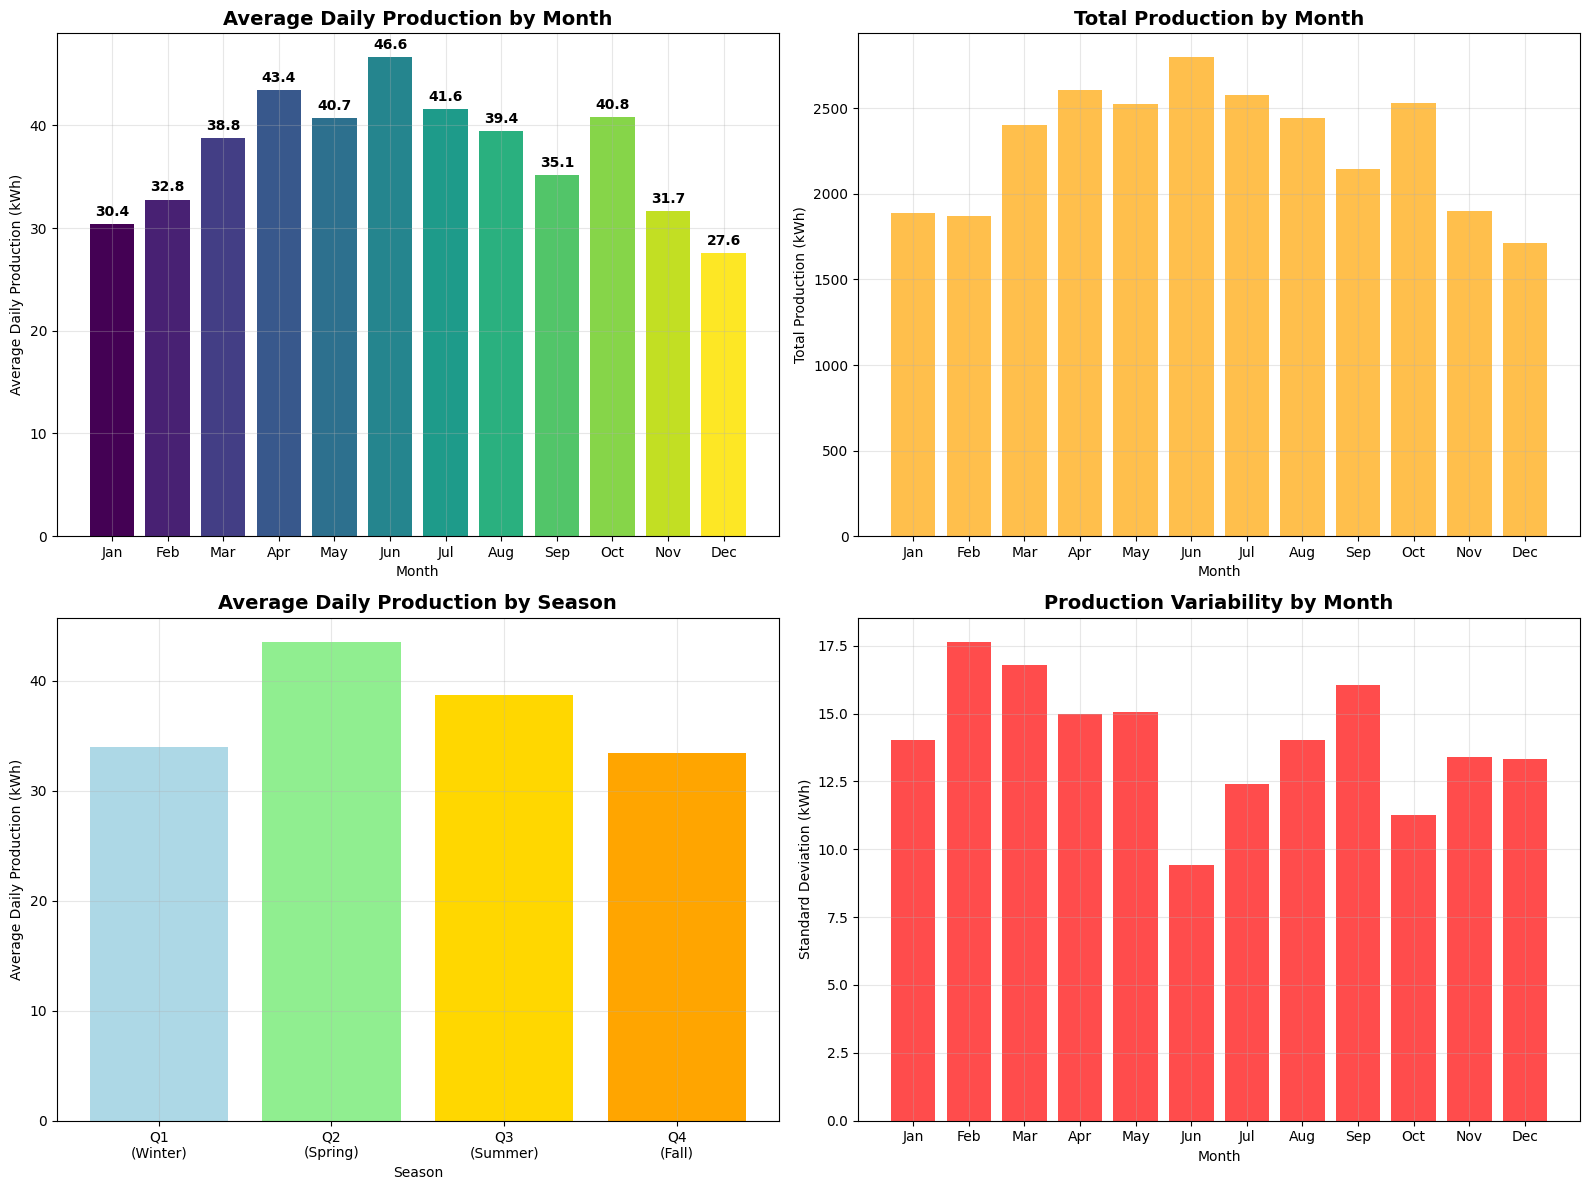

In [4]:
# Monthly production visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly averages
monthly_avg = daily_data.groupby(daily_data.index.month)['Production (kWh)'].mean()
bars = axes[0,0].bar(range(1, len(monthly_avg)+1), monthly_avg.values, 
                     color=plt.cm.viridis(np.linspace(0, 1, len(monthly_avg))))
axes[0,0].set_title('Average Daily Production by Month', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Daily Production (kWh)')
axes[0,0].set_xticks(range(1, len(monthly_avg)+1))
axes[0,0].set_xticklabels([month_names[i-1] for i in monthly_avg.index])
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, monthly_avg.values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# Monthly totals
monthly_total = daily_data.groupby(daily_data.index.month)['Production (kWh)'].sum()
axes[0,1].bar(range(1, len(monthly_total)+1), monthly_total.values, alpha=0.7, color='orange')
axes[0,1].set_title('Total Production by Month', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Total Production (kWh)')
axes[0,1].set_xticks(range(1, len(monthly_total)+1))
axes[0,1].set_xticklabels([month_names[i-1] for i in monthly_total.index])
axes[0,1].grid(True, alpha=0.3)

# Seasonal comparison (quarters)
seasonal_data = daily_data.groupby(daily_data.index.quarter)['Production (kWh)'].mean()
season_names = ['Q1\n(Winter)', 'Q2\n(Spring)', 'Q3\n(Summer)', 'Q4\n(Fall)']
colors = ['lightblue', 'lightgreen', 'gold', 'orange']
bars = axes[1,0].bar(range(1, len(seasonal_data)+1), seasonal_data.values, color=colors)
axes[1,0].set_title('Average Daily Production by Season', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Season')
axes[1,0].set_ylabel('Average Daily Production (kWh)')
axes[1,0].set_xticks(range(1, len(seasonal_data)+1))
axes[1,0].set_xticklabels(season_names)
axes[1,0].grid(True, alpha=0.3)

# Production variability by month
monthly_std = daily_data.groupby(daily_data.index.month)['Production (kWh)'].std()
axes[1,1].bar(range(1, len(monthly_std)+1), monthly_std.values, alpha=0.7, color='red')
axes[1,1].set_title('Production Variability by Month', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Standard Deviation (kWh)')
axes[1,1].set_xticks(range(1, len(monthly_std)+1))
axes[1,1].set_xticklabels([month_names[i-1] for i in monthly_std.index])
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Daily Production Patterns

In [5]:
# Hourly patterns analysis
if len(csv_data) > 0:
    csv_data['Hour'] = csv_data.index.hour
    csv_data['Month'] = csv_data.index.month
    
    # Average hourly production
    hourly_avg = csv_data.groupby('Hour')['Production (kWh)'].mean()
    
    print("=== DAILY PRODUCTION PATTERNS ===")
    print(f"Peak production hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.3f} kWh avg)")
    print(f"First significant production: {hourly_avg[hourly_avg > 0.01].index.min()}:00")
    print(f"Last significant production: {hourly_avg[hourly_avg > 0.01].index.max()}:00")
    
    # Daylight hours analysis
    daylight_hours = hourly_avg[hourly_avg > 0.01]
    print(f"Productive daylight hours: {len(daylight_hours)} hours")
    print(f"Peak period (>50% of max): {len(hourly_avg[hourly_avg > hourly_avg.max()*0.5])} hours")

=== DAILY PRODUCTION PATTERNS ===
Peak production hour: 11:00 (1.386 kWh avg)
First significant production: 6:00
Last significant production: 19:00
Productive daylight hours: 14 hours
Peak period (>50% of max): 7 hours


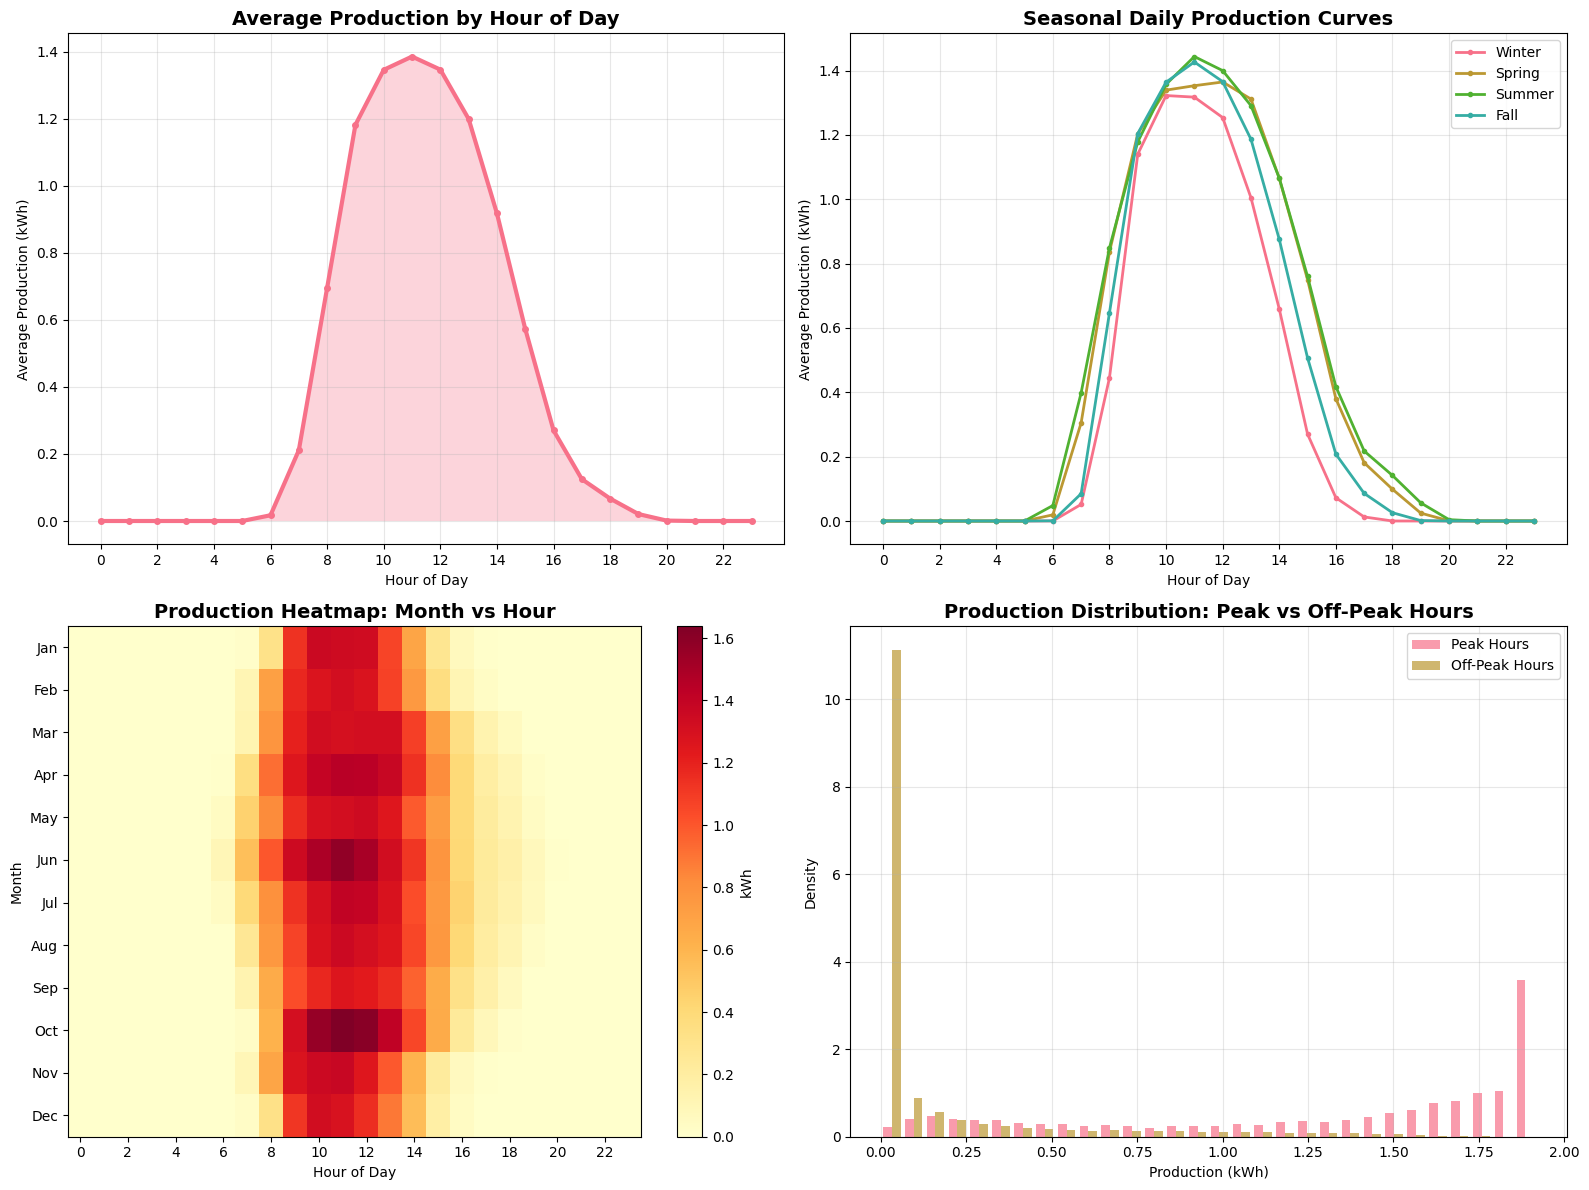

In [6]:
# Daily pattern visualization
if len(csv_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Overall hourly pattern
    axes[0,0].plot(hourly_avg.index, hourly_avg.values, linewidth=3, marker='o', markersize=4)
    axes[0,0].fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3)
    axes[0,0].set_title('Average Production by Hour of Day', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Average Production (kWh)')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xticks(range(0, 24, 2))
    
    # Seasonal daily patterns
    seasons = {
        'Winter': [12, 1, 2],
        'Spring': [3, 4, 5], 
        'Summer': [6, 7, 8],
        'Fall': [9, 10, 11]
    }
    
    for season, months in seasons.items():
        season_data = csv_data[csv_data['Month'].isin(months)]
        if len(season_data) > 0:
            season_hourly = season_data.groupby('Hour')['Production (kWh)'].mean()
            axes[0,1].plot(season_hourly.index, season_hourly.values, 
                          linewidth=2, label=season, marker='o', markersize=3)
    
    axes[0,1].set_title('Seasonal Daily Production Curves', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Average Production (kWh)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xticks(range(0, 24, 2))
    
    # Heatmap of hourly production by month
    hourly_monthly = csv_data.groupby(['Month', 'Hour'])['Production (kWh)'].mean().unstack()
    im = axes[1,0].imshow(hourly_monthly.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    axes[1,0].set_title('Production Heatmap: Month vs Hour', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('Month')
    axes[1,0].set_yticks(range(len(hourly_monthly.index)))
    axes[1,0].set_yticklabels([month_names[i-1] for i in hourly_monthly.index])
    axes[1,0].set_xticks(range(0, 24, 2))
    plt.colorbar(im, ax=axes[1,0], label='kWh')
    
    # Production distribution by hour
    peak_hours = hourly_avg[hourly_avg > hourly_avg.max() * 0.7].index
    peak_production = csv_data[csv_data['Hour'].isin(peak_hours)]['Production (kWh)']
    off_peak_production = csv_data[~csv_data['Hour'].isin(peak_hours)]['Production (kWh)']
    
    axes[1,1].hist([peak_production, off_peak_production], bins=30, alpha=0.7, 
                   label=['Peak Hours', 'Off-Peak Hours'], density=True)
    axes[1,1].set_title('Production Distribution: Peak vs Off-Peak Hours', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Production (kWh)')
    axes[1,1].set_ylabel('Density')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. System Performance Trends

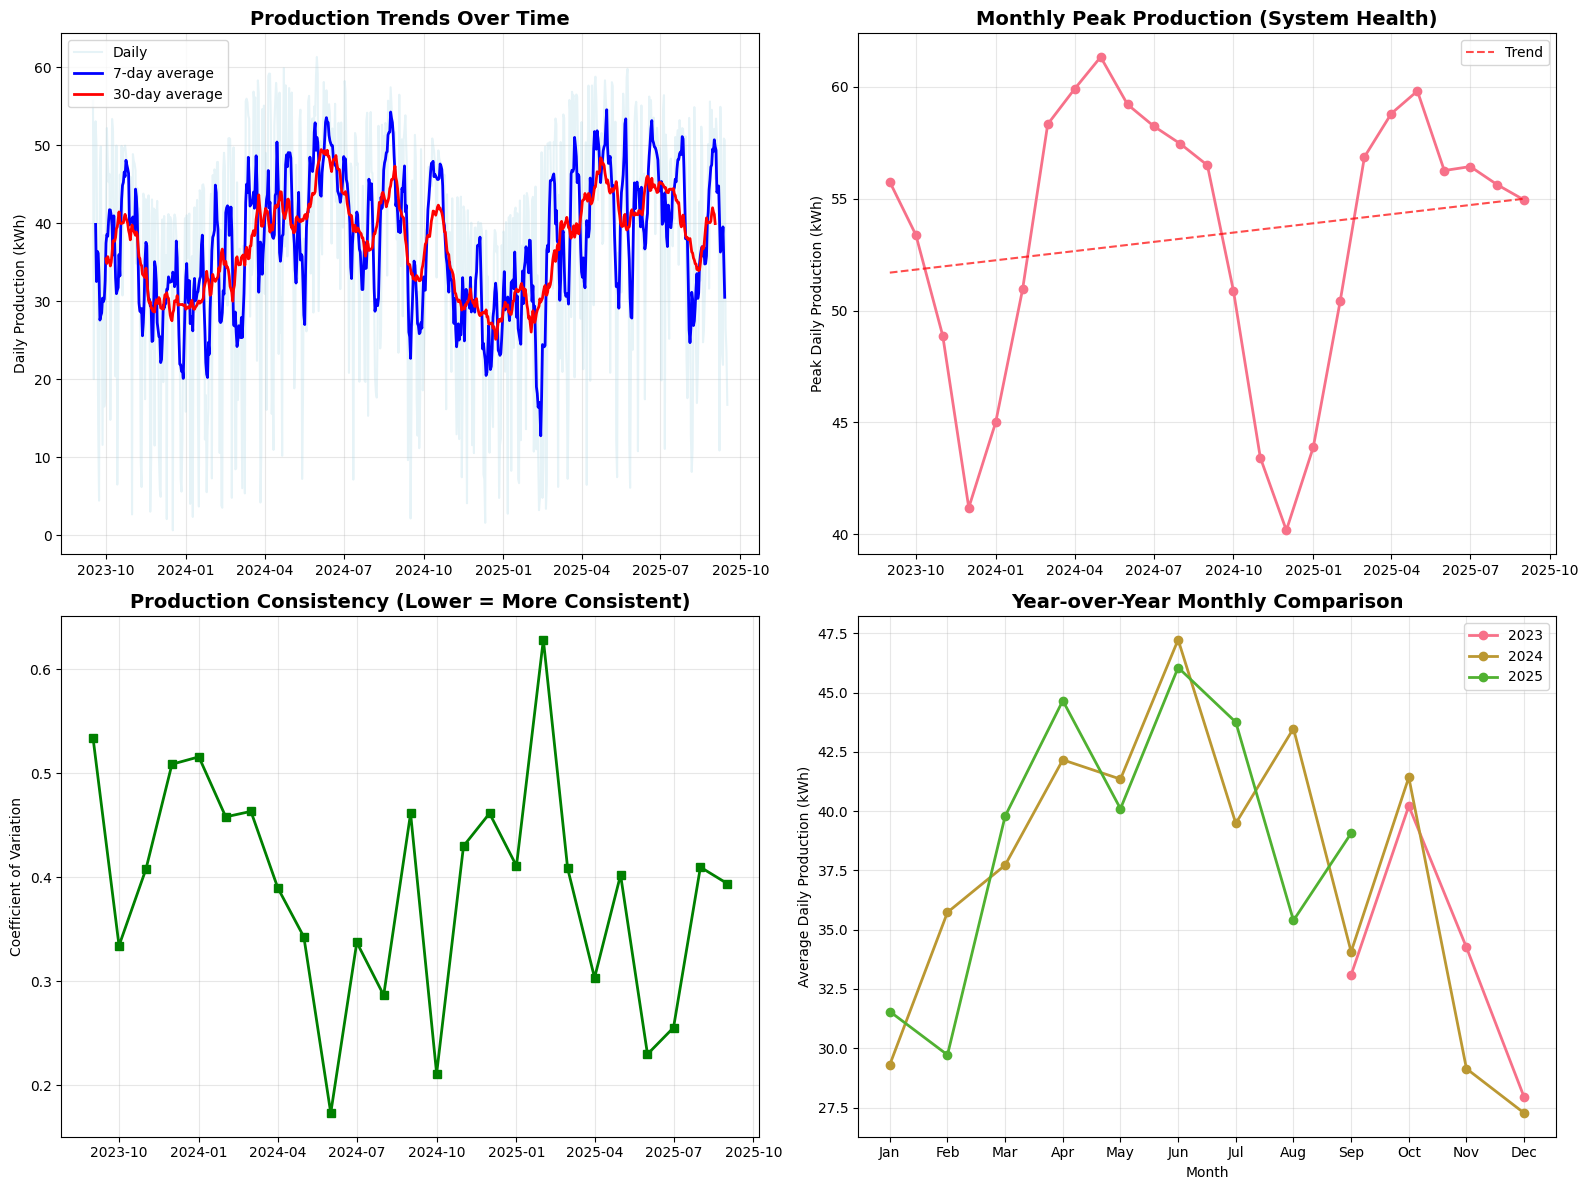

In [7]:
# Performance trends over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Rolling averages
daily_data['7day_avg'] = daily_data['Production (kWh)'].rolling(7, center=True).mean()
daily_data['30day_avg'] = daily_data['Production (kWh)'].rolling(30, center=True).mean()

# Daily production with trends
axes[0,0].plot(daily_data.index, daily_data['Production (kWh)'], alpha=0.3, color='lightblue', label='Daily')
axes[0,0].plot(daily_data.index, daily_data['7day_avg'], linewidth=2, color='blue', label='7-day average')
axes[0,0].plot(daily_data.index, daily_data['30day_avg'], linewidth=2, color='red', label='30-day average')
axes[0,0].set_title('Production Trends Over Time', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Daily Production (kWh)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Monthly peak production (system health indicator)
monthly_peaks = daily_data.groupby([daily_data.index.year, daily_data.index.month])['Production (kWh)'].max()
peak_dates = [datetime(year, month, 1) for (year, month) in monthly_peaks.index]
axes[0,1].plot(peak_dates, monthly_peaks.values, marker='o', linewidth=2, markersize=6)
axes[0,1].set_title('Monthly Peak Production (System Health)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Peak Daily Production (kWh)')
axes[0,1].grid(True, alpha=0.3)

# Add trend line
if len(monthly_peaks) > 3:
    from numpy.polynomial import Polynomial
    x_numeric = [(d - peak_dates[0]).days for d in peak_dates]
    p = Polynomial.fit(x_numeric, monthly_peaks.values, 1)
    trend_line = p(x_numeric)
    axes[0,1].plot(peak_dates, trend_line, '--', color='red', alpha=0.7, label='Trend')
    axes[0,1].legend()

# Performance consistency (coefficient of variation)
monthly_cv = daily_data.groupby([daily_data.index.year, daily_data.index.month])['Production (kWh)'].apply(
    lambda x: x.std() / x.mean() if x.mean() > 0 else 0
)
axes[1,0].plot(peak_dates, monthly_cv.values, marker='s', linewidth=2, color='green')
axes[1,0].set_title('Production Consistency (Lower = More Consistent)', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Coefficient of Variation')
axes[1,0].grid(True, alpha=0.3)

# Year-over-year comparison (if multi-year data)
yearly_comparison = daily_data.groupby([daily_data.index.month, daily_data.index.year])['Production (kWh)'].mean().unstack()
if yearly_comparison.shape[1] > 1:
    for year in yearly_comparison.columns:
        axes[1,1].plot(range(1, 13), yearly_comparison[year].values, 
                      marker='o', linewidth=2, label=f'{year}')
    axes[1,1].set_title('Year-over-Year Monthly Comparison', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Average Daily Production (kWh)')
    axes[1,1].set_xticks(range(1, 13))
    axes[1,1].set_xticklabels([m[:3] for m in month_names])
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
else:
    # Alternative: production vs day of year
    daily_data['day_of_year'] = daily_data.index.dayofyear
    doy_avg = daily_data.groupby('day_of_year')['Production (kWh)'].mean()
    axes[1,1].plot(doy_avg.index, doy_avg.values, alpha=0.7)
    axes[1,1].set_title('Average Production by Day of Year', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Day of Year')
    axes[1,1].set_ylabel('Average Production (kWh)')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Key Insights Summary

In [ ]:
print("=== KEY SEASONAL & TEMPORAL INSIGHTS ===")

# Seasonal insights
seasonal_avg = daily_data.groupby(daily_data.index.quarter)['Production (kWh)'].mean()
best_season = seasonal_avg.idxmax()
worst_season = seasonal_avg.idxmin()
season_names_full = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}

print(f"\n🌍 SEASONAL PATTERNS:")
print(f"  Best season: {season_names_full[best_season]} (Q{best_season}) - {seasonal_avg[best_season]:.1f} kWh/day")
print(f"  Worst season: {season_names_full[worst_season]} (Q{worst_season}) - {seasonal_avg[worst_season]:.1f} kWh/day")
print(f"  Seasonal variation: {seasonal_avg.max()/seasonal_avg.min():.1f}x difference")

# Compare with location expectations
location_summary = location.get_location_summary()
expected_variation = location_summary['seasonal_variation']
actual_variation = seasonal_avg.max()/seasonal_avg.min() - 1

print(f"\n📍 LOCATION-SPECIFIC INSIGHTS:")
print(f"  Location: {location.location_name}")
print(f"  Climate type: {location_summary['climate_type']}")
print(f"  Expected seasonal variation: {expected_variation:.1f}")
print(f"  Actual seasonal variation: {actual_variation:.1f}")
print(f"  Performance vs climate expectation: {'Higher' if actual_variation > expected_variation else 'Lower'} than typical for {location_summary['climate_type'].lower()} climates")

# Daily patterns
if len(csv_data) > 0:
    print(f"\n☀️ DAILY PATTERNS:")
    print(f"  Peak hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.3f} kWh average)")
    productive_hours = hourly_avg[hourly_avg > 0.01]
    print(f"  Productive hours: {productive_hours.index.min()}:00 to {productive_hours.index.max()}:00")
    print(f"  Total productive hours: {len(productive_hours)} hours/day")
    
    # Compare with theoretical daylight
    avg_daylight = (location_summary['summer_daylight_hours'] + location_summary['winter_daylight_hours']) / 2
    print(f"  Theoretical avg daylight: {avg_daylight:.1f} hours")
    print(f"  Solar utilization efficiency: {len(productive_hours)/avg_daylight*100:.0f}%")

# Performance trends
if len(monthly_peaks) > 6:
    recent_peaks = monthly_peaks.tail(6).mean()
    early_peaks = monthly_peaks.head(6).mean()
    trend_direction = "improving" if recent_peaks > early_peaks else "declining"
    print(f"\n📈 PERFORMANCE TRENDS:")
    print(f"  System performance: {trend_direction}")
    print(f"  Recent peak average: {recent_peaks:.1f} kWh")
    print(f"  Early peak average: {early_peaks:.1f} kWh")

# Production statistics
total_production = daily_data['Production (kWh)'].sum()
days_analyzed = len(daily_data)
print(f"\n📊 OVERALL STATISTICS:")
print(f"  Total production analyzed: {total_production:,.0f} kWh")
print(f"  Days analyzed: {days_analyzed:,} days")
print(f"  Average daily production: {total_production/days_analyzed:.1f} kWh/day")
print(f"  Estimated annual production: {(total_production/days_analyzed)*365:.0f} kWh/year")

print("\n✅ Seasonal and temporal analysis complete!")
print("\nNext steps:")
print("- Run 01c_baseline_ml_models.ipynb for machine learning forecasting")
print("- Run 02_weather_integration.ipynb for weather-enhanced analysis")